In [12]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install tensorflow
%pip install scikit-learn

  Using cached scikit_learn-1.5.2-cp311-cp311-win_amd64.whl.metadata (13 kB)
  Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.5.0-py3-none-any.whl.metadata (13 kB)
Using cached scikit_learn-1.5.2-cp311-cp311-win_amd64.whl (11.0 MB)
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
Using cached scipy-1.14.1-cp311-cp311-win_amd64.whl (44.8 MB)
Using cached threadpoolctl-3.5.0-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [5]:
import pandas as pd

In [6]:
# Hyperparameters
age_loss_weight = 0.5
gender_loss_weight = 0.5
learning_rate = 0.001

In [7]:
label_data = pd.read_csv(f"./validated_filtered_100.csv", sep=",")

In [8]:
label_data.isna().sum()

path        0
sentence    0
age         0
gender      0
dtype: int64

In [47]:
label_data.head()

,path,sentence,age,gender
0,common_voice_fr_17323684.mp3,Puis me regardant d'un air peu sympathique,fifties,female_feminine
1,common_voice_fr_19737278.mp3,Ronit est une jeune femme indépendante qui tra...,fifties,female_feminine
2,common_voice_fr_22078126.mp3,cinq,fifties,female_feminine
3,common_voice_fr_22078130.mp3,non,fifties,female_feminine
4,common_voice_fr_22765327.mp3,La technique des statues de terre cuite témoig...,fifties,female_feminine


In [8]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns


def load_audio_data(data_path, label_data):
    for path in label_data['path']:
        pass


def preprocess_audio_data(audio_data):
    return audio_data


def show_distrib(df):
    """
    Plot the distribution of age by gender
    :param df:
    :return:
    """
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(data=df, x='age', hue='gender', multiple='stack', stat='count')

    # Annotate the bars with their counts
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext=(0, 10), textcoords='offset points')

    plt.title('Distribution of Age by Gender')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()


def preprocess_label_data(label_data, keep_age=False):
    gender_dict = {
        'male_masculine': 0,
        'female_feminine': 1
    }
    label_data = label_data.copy()
    if keep_age:
        serie_age = label_data['age'].copy()
    label_data = pd.get_dummies(label_data, columns=['age'])
    label_data['gender'] = label_data['gender'].map(gender_dict)
    return pd.concat([label_data, serie_age], axis=1) if keep_age else label_data


def split_label_data(label_data, train_ratio=0.8, random_state=0):
    train_data, test_data = train_test_split(label_data, train_size=train_ratio, random_state=random_state,
                                             stratify=label_data['gender'])
    return train_data, test_data

In [9]:
Y_train, Y_test = split_label_data(preprocess_label_data(label_data,True))

In [178]:
Y_train.head()

,path,sentence,gender,age_fifties,age_fourties,age_seventies,age_sixties,age_teens,age_thirties,age_twenties,age
4632,common_voice_fr_38307681.mp3,Que dites-vous à l’âme humaine,1,False,False,False,False,False,False,True,twenties
12852,common_voice_fr_20517067.mp3,Il reçoit une éducation de qualité dans divers...,1,False,False,False,True,False,False,False,sixties
197,common_voice_fr_23617240.mp3,"Il était composé des cantons de Jussey, Amance...",1,True,False,False,False,False,False,False,fifties
7780,common_voice_fr_18251575.mp3,dix allée de l'Alamanda,0,False,False,False,False,True,False,False,teens
9015,common_voice_fr_37230167.mp3,Deux galeries courent le long des parois sur l...,0,False,True,False,False,False,False,False,fourties


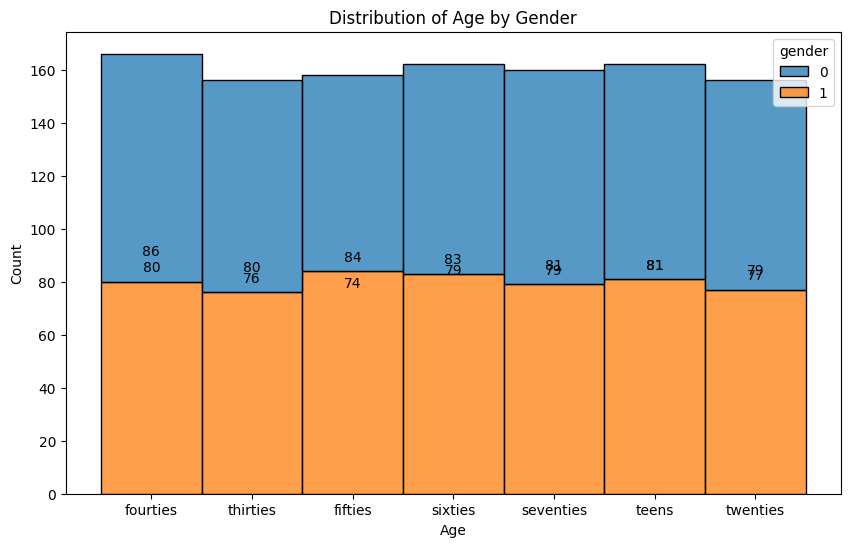

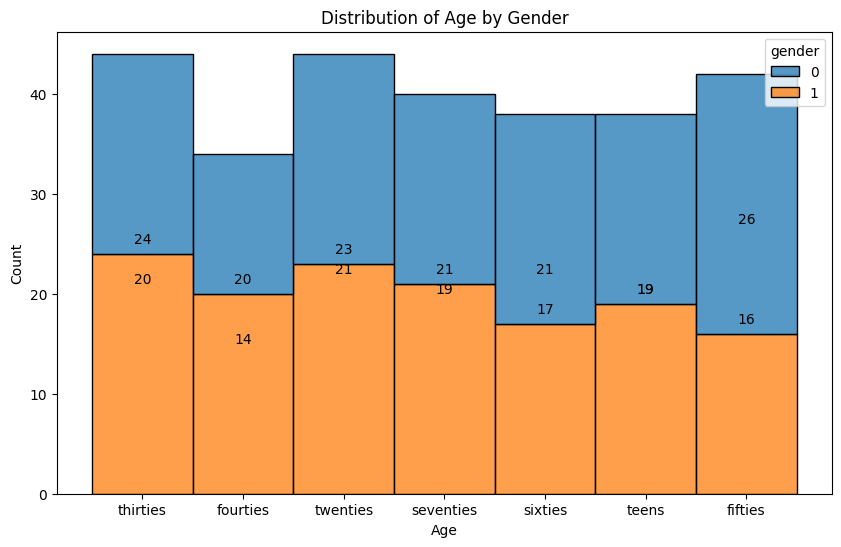

In [51]:
# Only run if keep age is True
show_distrib(Y_train)
show_distrib(Y_test)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, TimeDistributed, Flatten, LSTM, Input,Conv1D, Conv2D, MaxPooling2D

def custom_loss(y_true, y_pred):
    """
    Custom loss function for the model. Must predict the age and gender of the speaker.
    prediction: [X X X X X X X] + [X]
                    age           gender
    Use the following loss functions:
    - age: mean squared error
    - gender: binary crossentropy
    :param y_true:
    :param y_pred:
    :return:
    """
    age_true = y_true[:, :-1]
    age_pred = y_pred[:, :-1]
    gender_true = y_true[:, -1]
    gender_pred = y_pred[:, -1]
    age_loss = tf.keras.losses.MeanSquaredError()(age_true, age_pred)
    gender_loss = tf.keras.losses.BinaryCrossentropy()(gender_true, gender_pred)
    return age_loss_weight * age_loss + gender_loss_weight * gender_loss

def build_model(input_shape, output_shape):
    """
    Build the model to predict the age and
    :param input_shape:
    :param output_shape:
    :return:
    """
    model = tf.keras.models.Sequential()
    model.add(Conv1D(32, (3, 3), activation='relu', input_shape=input_shape)) 
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv1D(64, (3, 3), activation='relu')) 
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv1D(64, (3, 3), activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.add(Dense(output_shape, activation="softmax"))
    model.summary()
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=custom_loss)
    return model

In [10]:
import numpy as np
data = np.load("./processed/common_voice_fr_37031557.npy")
print(data.shape)
# model = build_model(data.shape[1], 7)

(128, 862)


In [11]:
def load_audio_data(df):
    df_audio = df.copy()
    df_audio['audio_data'] = df['path'].apply(lambda x: np.load(f"./processed/{x.replace('.mp3', '.npy')}"))   
    return df_audio
import time


def model_fit(model, X_train, Y_train, X_test, Y_test, log_df,batch_size=32, epochs=10):
    """
    Fit the model and save it in the log dataframe
    :param model: model to fit 
    :param X_train: training data
    :param Y_train: training labels
    :param X_test: testing data
    :param Y_test: testing labels
    :param log_df: dataframe to save the model
    """
    t0 = time.time()
    model.fit(X_train, Y_train, validation_data=(X_test, Y_test), batch_size=batch_size, epochs=epochs)
    model.save(f"./model_{len(log_df)}.keras")
    t1 = time.time()
    log_entry = pd.DataFrame({
        'model': [model],
        'time': [t1 - t0],
        'batch_size': [batch_size],
        'epochs': [epochs],
        'history': model.history.history
    })
    log_df = pd.concat([log_df, log_entry], ignore_index=True)
    
    return log_df

In [12]:
df_audio_train = load_audio_data(Y_train)
df_audio_test = load_audio_data(Y_test)


X_train_audio = np.array(df_audio_train.copy()['audio_data'].tolist()).astype(np.float32)
X_test_audio = np.array(df_audio_test.copy()['audio_data'].tolist()).astype(np.float32)

Y_train_audio = df_audio_train.drop(columns=['path', 'audio_data','sentence','age']).astype(np.float32)
Y_train_audio = Y_train_audio.astype(int)
Y_test_audio = df_audio_test.drop(columns=['path', 'audio_data','sentence','age']).astype(np.float32)
Y_test_audio = Y_test_audio.astype(int)
print(Y_train_audio.head())

# print(Y_train.shape)

# Print shapes and data types to verify
print(X_train_audio.shape, X_train_audio.dtype)
print(Y_train_audio.shape)
print(X_test_audio.shape, X_test_audio.dtype)
print(Y_test_audio.shape)




      gender  age_fifties  age_fourties  age_seventies  age_sixties  \
898        1            0             1              0            0   
346        0            0             0              0            0   
211        1            0             0              0            0   
63         1            1             0              0            0   
1351       0            0             0              0            1   

      age_teens  age_thirties  age_twenties  
898           0             0             0  
346           0             1             0  
211           0             1             0  
63            0             0             0  
1351          0             0             0  
(1120, 128, 862) float32
(1120, 8)
(280, 128, 862) float32
(280, 8)


In [13]:
print(Y_train_audio.shape)
model = build_model((128, 862), Y_train_audio.shape[1])
log = model_fit(model, X_train_audio, Y_train_audio, X_test_audio, Y_test_audio, pd.DataFrame())
log.head()

(1120, 8)


d:\VS CODE\individu-feature-from-voice\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: The `kernel_size` argument must be a tuple of 1 integers. Received kernel_size=(3, 3)

In [167]:
def load_and_predict(model_path, np_data):
    """
    Load a model from a .h5 file and make predictions on the provided NumPy data.
    
    :param model_path: Path to the .h5 model file.
    :param np_data: NumPy array containing the input data.
    """
    age_categories = ['teens', 'twenties', 'thirties', 'forties', 'fifties', 'sixties', 'seventies']
    gender_categories = ['male', 'female']
    # Load the model from the .h5 file
    model = tf.keras.models.load_model(model_path, custom_objects={'custom_loss': custom_loss})
    
    # Ensure the input data is a NumPy array of type float32
    np_data = np.array(np_data).astype(np.float32)
    
    # Print the shape and dtype of the input data
    print("Input data shape:", np_data.shape, "dtype:", np_data.dtype)
    
    # Make predictions
    predictions = model.predict(np_data)
    
    # Print the predictions
    print("Predictions:", predictions)


    for i, prediction in enumerate(predictions):
        age_pred = prediction[:7]
        gender_pred = prediction[7:]
        print(f"Age prediction: {age_pred}, Gender prediction: {gender_pred}")
        age_index = np.argmax(age_pred)
        gender_index = np.round(gender_pred).astype(int)  # Assuming gender prediction is a probability
        print(age_index,gender_index)
        
        age_category = age_categories[age_index]
        gender_category = gender_categories[gender_index[0]]
        
        print(f"Sample {i+1}: Age - {age_category}, Gender - {gender_category}")

    


In [181]:
data = [np.load(f"./processed/{path.replace('.mp3', '.npy')}") for path in Y_train['path'].head(5)]
np_data = np.array(data).reshape(-1, 128, 862)

model_path = "./model_0.keras"
load_and_predict(model_path, np_data)

# print from Y_train the expected values based on file name
for path in Y_train['path'].head(5):
    expected = Y_train.loc[Y_train['path'] == path]
    print(f"File: {path}")
    print(f"Age expected = {expected['age'].values[0]}, Gender expected = {expected['gender'].values[0]}")


Input data shape: (5, 128, 862) dtype: float32
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predictions: [[0.42373207 0.07550263 0.07302667 0.07168129 0.07435957 0.07046105
  0.07391555 0.13732113]
 [0.4237381  0.07550184 0.0730258  0.07167994 0.07435881 0.0704602
  0.07391475 0.13732062]
 [0.4237287  0.07550309 0.07302717 0.07168209 0.07435998 0.07046153
  0.07391599 0.13732141]
 [0.42156884 0.07592505 0.07328134 0.07242474 0.07457058 0.0708379
  0.07416435 0.13722718]
 [0.42373478 0.07550234 0.07302625 0.07168067 0.07435924 0.07046068
  0.07391516 0.13732088]]
Age prediction: [0.42373207 0.07550263 0.07302667 0.07168129 0.07435957 0.07046105
 0.07391555], Gender prediction: [0.13732113]
0 [0]
Sample 1: Age - teens, Gender - male
Age prediction: [0.4237381  0.07550184 0.0730258  0.07167994 0.07435881 0.0704602
 0.07391475], Gender prediction: [0.13732062]
0 [0]
Sample 2: Age - teens, Gender - male
Age prediction: [0.4237287  0.07550309 0.07302717 0.07168209 0.07435998 0.07046153
 0.07391599], 